In [1]:
#packages
using Pkg #package manager
Pkg.activate(".") #applies any following packages to this directory

  Activating project at `~/Projects/Indistinguishability-Repo`


In [3]:
using Catalyst;
using MomentClosure;
using DifferentialEquations;
using Sundials;
using LinearAlgebra;
using CairoMakie;
using DataFrames;
using Latexify;
using Colors;
using CSV;
using LaTeXStrings;

In [4]:
#useful functions

#function to convert a list of numbers separated by spaces and commas in a String object into a vector of Float64 numbers
function string_to_float64_vec(long_string)
    
    string_1 = split(long_string, ',');
    string_2 = replace.(string_1, " " => "");
    vec = parse.(Float64, string_2);
    
    return vec;
    
end

#function to compute the theoretical prefactor given an N-state model and initial state
function compute_theory_prefactor(N_::Int64, j_::Int64, ps_::Vector{Float64})
    prefactor = ps_[N_+1]; #initial prefactor value = transcription rate
    for i in j_:1:(N_-1)
        prefactor *= ps_[i]; #prefactor is product of transcription rate and rates leading into 
    end
    prefactor = prefactor/factorial(N_-j_+1);
    return prefactor;
end

#function to compute the expected gene state given a marginal gene state distribution
function compute_expectation_G(u0_dist, N_)
    
    expectation_value = 0.0;
    
    for i in 1:1:length(u0_dist)
        expectation_value += (i)*u0_dist[i];
    end
    
    return expectation_value;
end

#function to compute the std dev of the gene state given a marginal gene state distribution
function compute_stddev_G(u0_dist, N__)
    
    #compute the expected value
    expected_value = compute_expectation_G(u0_dist, N__);
    
    #compute the variance
    variance_value = 0.0;
    for i in 1:1:length(u0_dist)
        variance_value += ( ( (i) - expected_value )^2 )*u0_dist[i];
    end
    
    #compute the std dev
    stddev_value = sqrt(variance_value);
    
    return stddev_value;
    
end

compute_stddev_G (generic function with 1 method)

In [5]:
#colours (for plotting)
bblue = RGBAf(0,0,255/255,1);
yyellow = RGBAf(255/255,215/255,0,1);
oorange = RGBAf(255/255,138/255,78/255,1);
ppurple = RGBAf(157/255,2/255,215/255,1);
ggreen = RGBAf(0,173/255,0,1);

In [6]:
### Fig S15

In [7]:
#Import Fig S15 data

filename_S15 = "SyntheticData_G1G3_MixedInitialConditions.csv";
df_data_S15 = CSV.read(filename_S15, DataFrame);

In [8]:
#Extract data

nrows = size(df_data_S15)[1]; #number of rows in data frame

x_range = df_data_S15[!,1]; #values of x used for initial conditions
LinReg_intercept_vec = df_data_S15[!,4]; #linear regression intercept (using CME mean values)
LinReg_slope_vec = df_data_S15[!,5]; #linear regression slope (using CME mean values)
LinReg_Rsq_vec = df_data_S15[!,6]; #linear regression R-squared (using CME mean values)
LinReg_RSS_vec = df_data_S15[!,7]; #linear regression RSS (using CME mean values)
NonLinReg_prefactor_vec = df_data_S15[!,9]; #nonlinear regression prefactor (using CME mean values)
NonLinReg_exponent_vec = df_data_S15[!,10]; #nonlinear regression exponent (using CME mean values)
NonLinReg_Rsq_vec = df_data_S15[!,11]; #nonlinear regression R-squared (using CME mean values)
NonLinReg_RSS_vec = df_data_S15[!,12]; #nonlinear regression RSS (using CME mean values)

LinReg_intercept_SSA_vec = df_data_S15[!,15]; #linear regression intercept (using SSA mean values)
LinReg_slope_SSA_vec = df_data_S15[!,16]; #linear regression slope (using SSA mean values)
LinReg_Rsq_SSA_vec = df_data_S15[!,17]; #linear regression R-squared (using SSA mean values)
LinReg_RSS_SSA_vec = df_data_S15[!,18]; #linear regression RSS (using SSA mean values)
NonLinReg_prefactor_SSA_vec = df_data_S15[!,20]; #nonlinear regression prefactor (using SSA mean values)
NonLinReg_exponent_SSA_vec = df_data_S15[!,21]; #nonlinear regression exponent (using SSA mean values)
NonLinReg_Rsq_SSA_vec = df_data_S15[!,22]; #nonlinear regression R-squared (using SSA mean values)
NonLinReg_RSS_SSA_vec = df_data_S15[!,23]; #nonlinear regression RSS (using SSA mean values)

#for the data below extra processing steps are needed to convert into the appropriate format
u0_vec = Vector{Vector{Float64}}(); #vector of initial conditions (marginal gene state distribution)
CME_mean_vec = Vector{Vector{Float64}}(); #vector of mean mRNA counts sampled from the CME
LinReg_regression_vec = Vector{Vector{Float64}}(); #vector containing the regression from the linear regression on the CME sampled means
NonLinReg_regression_vec = Vector{Vector{Float64}}(); #vector containing the regression from the nonlinear regression on the CME sampled means
SSA_mean_vec = Vector{Vector{Float64}}(); #vector of mean mRNA counts sampled from the SSA
LinReg_regression_SSA_vec = Vector{Vector{Float64}}(); #vector containing the regression from the linear regression on the SSA sampled means
NonLinReg_regression_SSA_vec = Vector{Vector{Float64}}(); #vector containing the regression from the nonlinear regression on the SSA sampled means
for i in 1:1:nrows
    push!(u0_vec, string_to_float64_vec(df_data_S15[!,2][i][2:end-1]));
    push!(CME_mean_vec, string_to_float64_vec(df_data_S15[!,3][i][2:end-1]));
    push!(LinReg_regression_vec, string_to_float64_vec(df_data_S15[!,8][i][2:end-1]));
    push!(NonLinReg_regression_vec, string_to_float64_vec(df_data_S15[!,13][i][2:end-1]));
    push!(SSA_mean_vec, string_to_float64_vec(df_data_S15[!,14][i][2:end-1]));
    push!(LinReg_regression_SSA_vec, string_to_float64_vec(df_data_S15[!,19][i][2:end-1]));
    push!(NonLinReg_regression_SSA_vec, string_to_float64_vec(df_data_S15[!,24][i][2:end-1]));
end

In [9]:
#Define 5-state model reaction network
rn_5sm = @reaction_network begin
    k_1*(1 - G_2 - G_3 - G_4 - G_5), ∅ --> G_2
    k_2, G_2 --> G_3
    k_3, G_3 --> G_4
    k_4, G_4 --> G_5
    k_5, G_5 --> ∅
    ρ, G_5 --> G_5 + M
    d, M --> ∅
end k_1 k_2 k_3 k_4 k_5 ρ d

Model ##ReactionSystem#315
States (5):
  G_2(t)
  G_3(t)
  G_4(t)
  G_5(t)
  M(t)
Parameters (7):
  k_1
  k_2
  k_3
  k_4
  k_5
  ρ
⋮

In [10]:
#Generate the moment equations (means of each species)
moment_eqns = generate_central_moment_eqs(rn_5sm, 1);
latexify(moment_eqns)

L"\begin{align*}
\frac{d\mu_{1 0 0 0 0}}{dt} =& k_{1} - k_{1} \mu_{0 0 0 1 0} - k_{1} \mu_{0 0 1 0 0} - k_{1} \mu_{0 1 0 0 0} - k_{1} \mu_{1 0 0 0 0} - k_{2} \mu_{1 0 0 0 0} \\
\frac{d\mu_{0 1 0 0 0}}{dt} =& k_{2} \mu_{1 0 0 0 0} - k_{3} \mu_{0 1 0 0 0} \\
\frac{d\mu_{0 0 1 0 0}}{dt} =& k_{3} \mu_{0 1 0 0 0} - k_{4} \mu_{0 0 1 0 0} \\
\frac{d\mu_{0 0 0 1 0}}{dt} =& k_{4} \mu_{0 0 1 0 0} - k_{5} \mu_{0 0 0 1 0} \\
\frac{d\mu_{0 0 0 0 1}}{dt} =& \rho \mu_{0 0 0 1 0} - d \mu_{0 0 0 0 1}
\end{align*}
"

In [11]:
#Parameter set, initial conditions, and time to solve over

ps = [18.6, 18.3, 13.0, 29.7, 1.3, 880.0, 1.0]; #attempt 2

N = 5; #number of states
j = 1; #initial state (just to calculate t_on)

#compute switching on time, say t_on (see SI of paper for further details)
prefactor = compute_theory_prefactor(N, j, ps); #compute power law prefactor
final_mean = 40.0; #fix final measurement mean mRNA count
t_on = 1.0*(final_mean/prefactor)^(1/(N-j+1)); #compute t_on
t_save = [t_on/5, 2*t_on/5, 3*t_on/5, 4*t_on/5, t_on];

#time to solve over
t_span = (0.0, t_on);

#times to save the mean at for a smooth curve
t_curve = 10 .^(range(-5,stop=log10(t_on),length=100));

In [12]:
#Solve the CME for the mean mRNA count curves, for each initial condition

#vectors to store results
mean_t_vec = Vector{}();
mean_t_curve_vec = Vector{}();

#initial conditions
m0 = 0.0; #initial mean mRNA count
#x_range = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0];

for x in x_range
    
    u0 = [0.0, x, 0.0, 0.0, m0]; #G_2, G_3, G_4, G_5, M
    u0_mixed = [1.0-sum(u0), u0[1], u0[2], u0[3], u0[4]];
    u0map = deterministic_IC(u0, moment_eqns);

    #construct ODE moment problems and solve the moment equations
    prob = ODEProblem(moment_eqns, u0map, t_span, ps);
    sol = solve(prob, CVODE_BDF(), abstol=1e-15, reltol=1e-15, saveat=t_save);
    sol_curve = solve(prob, CVODE_BDF(), abstol=1e-15, reltol=1e-15, saveat=t_curve);

    #extract mean mRNA count
    mean_t_mixed = [sol.u[i][end] for i in 1:1:length(sol.u)];
    mean_t_mixed_curve = [sol_curve.u[i][end] for i in 1:1:length(sol_curve.u)];
    
    #save mean curves
    push!(mean_t_vec, mean_t_mixed);
    push!(mean_t_curve_vec, mean_t_mixed_curve);
    
end

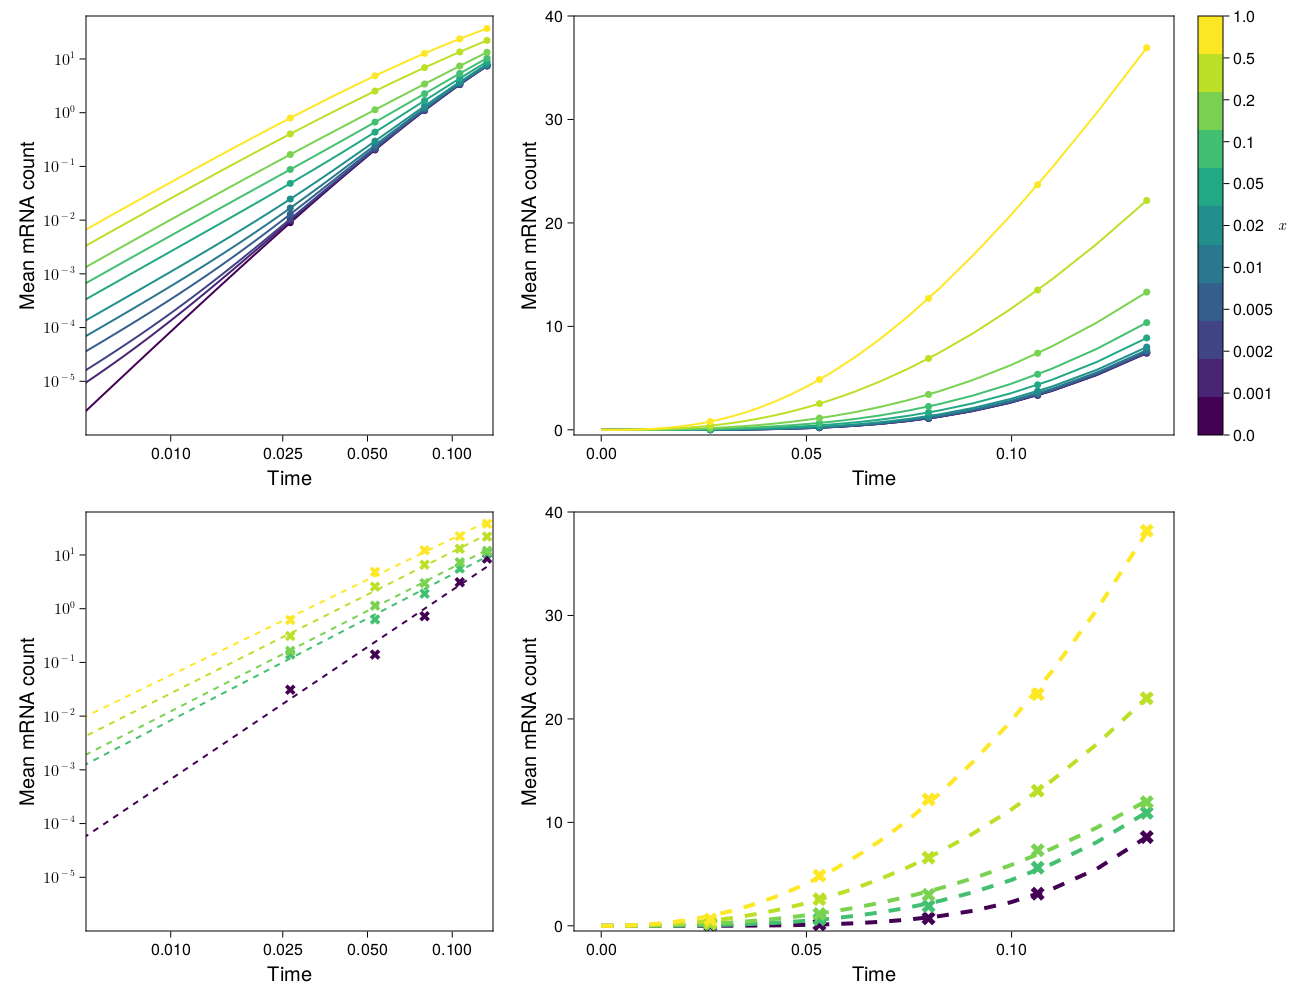

In [13]:
#Plot Fig. S15

fig_S15 = Figure(resolution = (1300, 1000))

#Plot mean mRNA count induction curve from the CME

#log-log plot
ax = Axis(fig_S15[1,1], xlabel="Time", ylabel="Mean mRNA count", 
    xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16, xscale=log10, yscale=log10,
    xticks=([10^-2, 0.025, 0.05, 10^-1]), yticks=([10^-5,10^-4,10^-3,10^-2,10^-1,10^0,10^1,10^2],
        [L"10^{-5}",L"10^{-4}",L"10^{-3}",L"10^{-2}",L"10^{-1}",L"10^{0}",L"10^{1}",L"10^{2}"]))

#curves
for i in 1:1:nrows
    CairoMakie.lines!(t_curve, mean_t_curve_vec[i], linewidth=2, color=i, colormap=:viridis, colorrange = (1, nrows))
    CairoMakie.scatter!(t_save, mean_t_vec[i], markersize=10, color=i, colormap=:viridis, colorrange = (1, nrows))
    #CairoMakie.lines!(t_curve, LinReg_regression_vec[i], color=:grey, linewidth=2, linestyle=:dash)
end
xlims!(0.05*10^-1, 1.05*t_on)
ylims!(10^-6, 10^1.8)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#linear plot
ax = Axis(fig_S15[1,2], xlabel="Time", ylabel="Mean mRNA count", 
    xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)

#curves
for i in 1:1:nrows
    CairoMakie.lines!(t_curve, mean_t_curve_vec[i], linewidth=2, color=i, colormap=:viridis, colorrange = (1, nrows))
    CairoMakie.scatter!(t_save, mean_t_vec[i], markersize=10, color=i, colormap=:viridis, colorrange = (1, nrows))
    #CairoMakie.lines!(t_curve, NonLinReg_regression_vec[i], color=:grey, linewidth=2, linestyle=:dash)
end
ylims!(-0.5, 40)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#colour bar
cbar = Colorbar(fig_S15[1, 3], limits = (0, 1), colormap = cgrad(:viridis, length(x_range), categorical = true), size = 25, 
    label=L"x", labelrotation=0)
cbar.ticks[] = (range(start=0,stop=1,length=length(x_range)), string.(x_range))

colsize!(fig_S15.layout, 2, Fixed(600))

#Plot mean mRNA count induction curve from the SSA

#log-log plot
ax = Axis(fig_S15[2,1], xlabel="Time", ylabel="Mean mRNA count", 
    xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16, xscale=log10, yscale=log10,
    xticks=([10^-2, 0.025, 0.05, 10^-1]), yticks=([10^-5,10^-4,10^-3,10^-2,10^-1,10^0,10^1,10^2],
        [L"10^{-5}",L"10^{-4}",L"10^{-3}",L"10^{-2}",L"10^{-1}",L"10^{0}",L"10^{1}",L"10^{2}"]))

#curves
for i in 1:1:nrows
    if i==1 || i==8 || i==9 || i==10 || i==11 #only plot some of the initial conditions
        CairoMakie.lines!(t_curve, LinReg_regression_SSA_vec[i], linewidth=2, linestyle=:dash, color=i, colormap=:viridis, colorrange = (1, nrows))
        CairoMakie.scatter!(t_save, SSA_mean_vec[i], markersize=15, color=i, colormap=:viridis, colorrange = (1, nrows), marker=:xcross)
    end
end

xlims!(0.05*10^-1, 1.05*t_on)
ylims!(10^-6, 10^1.8)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#linear plot
ax = Axis(fig_S15[2,2], xlabel="Time", ylabel="Mean mRNA count", 
    xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)

#curves
for i in 1:1:nrows
    if i==1 || i==8 || i==9 || i==10 || i==11 #only plot some of the initial conditions
        CairoMakie.lines!(t_curve, NonLinReg_regression_SSA_vec[i], linewidth=4, linestyle=:dash, color=i, colormap=:viridis, colorrange = (1, nrows))
        CairoMakie.scatter!(t_save, SSA_mean_vec[i], markersize=20, color=i, colormap=:viridis, colorrange = (1, nrows), marker=:xcross)
    end
end
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
ylims!(-0.5, 40)

colsize!(fig_S15.layout, 2, Fixed(600))

fig_S15

In [14]:
### Fig S16

In [15]:
#Import Fig S15 data

filename_S16 = "SyntheticData_ParameterSweep_MixedInitialConditions.csv";
df_data_S16 = CSV.read(filename_S16, DataFrame);

In [16]:
#Extract data

nrows_2 = size(df_data_S16)[1]; #number of rows in data frame

ss_mean_vec = df_data_S16[!,10]; #steady-state mean mRNA count
LinReg_intercept_scatterplot = df_data_S16[!,14]; #linear regression intercept
LinReg_slope_scatterplot = df_data_S16[!,16]; #linear regression slope
LinReg_Rsq_scatterplot = df_data_S16[!,17]; #linear regression R-squared
LinReg_RSS_scatterplot = df_data_S16[!,18]; #linear regression RSS
NonLinReg_prefactor_scatterplot = df_data_S16[!,19]; #nonlinear regression prefactor
NonLinReg_exponent_scatterplot = df_data_S16[!,20]; #nonlinear regression exponent
NonLinReg_Rsq_scatterplot = df_data_S16[!,21]; #nonlinear regression R-squared
NonLinReg_RSS_scatterplot = df_data_S16[!,22]; #nonlinear regression RSS
data_sampling_procedure = string.(df_data_S16[!,23]); #initial condition sampling procedure tag (used for plotting)

#for the data below extra processing steps are needed to convert into the appropriate format
u0_vec_scatterplot = Vector{Vector{Float64}}(); #vector of initial conditions (marginal gene state distribution)
sampled_means_scatterplot = Vector{Vector{Float64}}(); #vector of mean mRNA counts sampled from the CME
sampling_times_scatterplot = Vector{Vector{Float64}}(); #vector of times used to take samples of mean mRNA count from the CME_mean_vec
for i in 1:1:nrows_2
    push!(u0_vec_scatterplot, string_to_float64_vec(df_data_S16[!,2][i][2:end-1]));
    push!(sampled_means_scatterplot, string_to_float64_vec(df_data_S16[!,12][i][2:end-1]));
    push!(sampling_times_scatterplot, string_to_float64_vec(df_data_S16[!,13][i][2:end-1]));
end

In [17]:
#compute the standard deviation of the initial conditions
stddev_u0_vec = Vector{Float64}();
for i in 1:1:nrows_2
    u0 = u0_vec_scatterplot[i];
    stddev = compute_stddev_G(u0, 5);
    push!(stddev_u0_vec, stddev);
end

In [18]:
#collect all the observations from different sampling procedures separately (for plotting)
A1_idxs = Vector{Int64}();
A4_idxs = Vector{Int64}();
B1_idxs = Vector{Int64}();
B4_idxs = Vector{Int64}();
C_idxs = Vector{Int64}();
D_idxs = Vector{Int64}();

for idx in 1:1:length(data_sampling_procedure)
    if data_sampling_procedure[idx]=="A1"
        push!(A1_idxs, idx);
    elseif data_sampling_procedure[idx]=="A4"
        push!(A4_idxs, idx);
    elseif data_sampling_procedure[idx]=="B1"
        push!(B1_idxs, idx);
    elseif data_sampling_procedure[idx]=="B4"
        push!(B4_idxs, idx);
    elseif data_sampling_procedure[idx]=="C"
        push!(C_idxs, idx);
    elseif data_sampling_procedure[idx]=="D"
        push!(D_idxs, idx);
    end
end

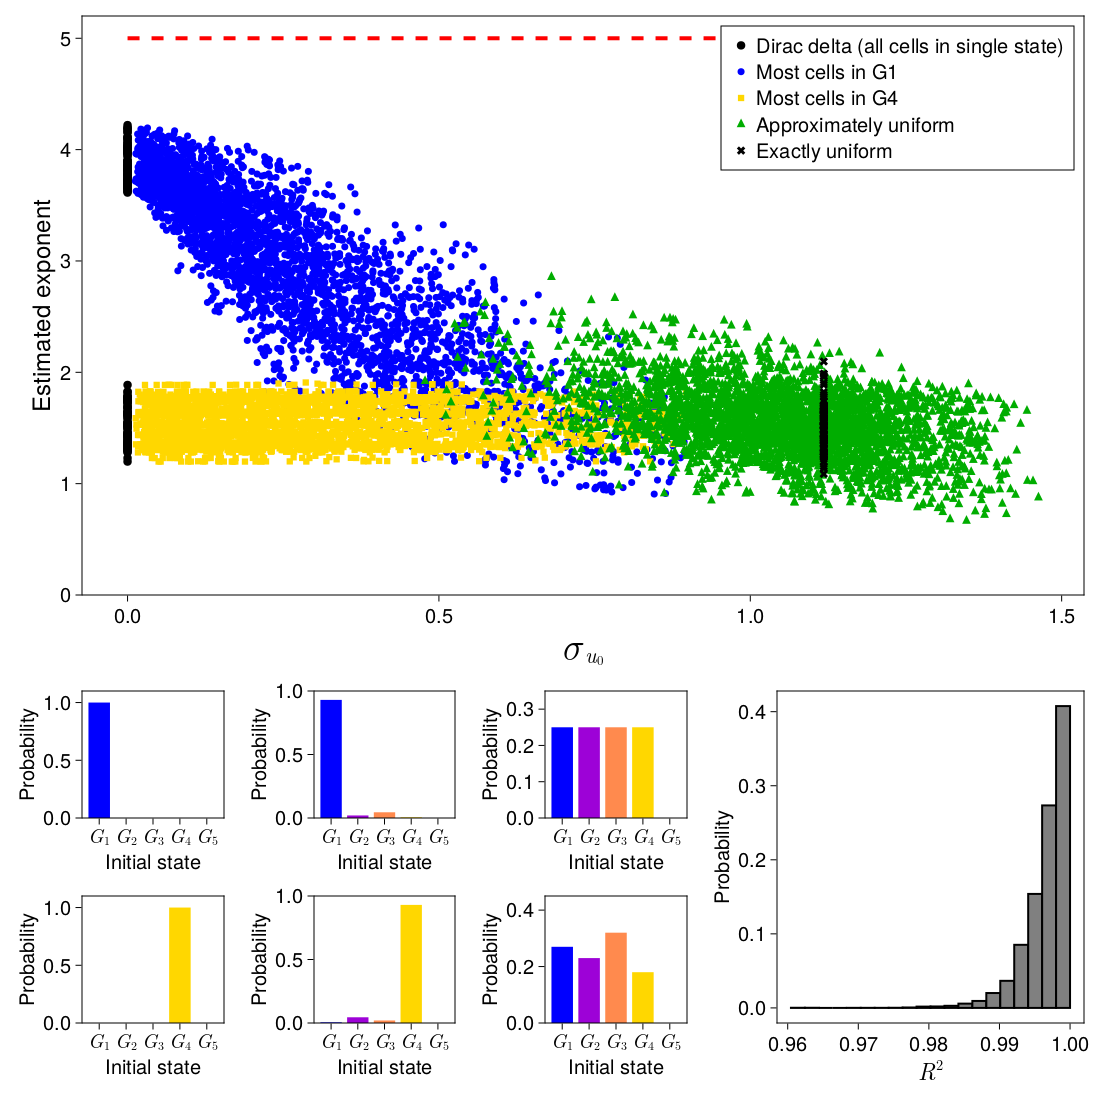

In [19]:
#Plot Fig. S16

#figure options
ticklabelsize_barchart = 20;
xtick_barchart_vector = [L"G_1", L"G_2", L"G_3", L"G_4", L"G_5"];

fig_S16 = Figure(resolution = 2.2 .*(500, 500))

#Estimated exponent scatterplot
ax = Axis(fig_S16[1:4,1:5], xlabel=L"\sigma_{u_0}", ylabel="Estimated exponent", 
    xlabelsize=36, xticklabelsize=20, ylabelsize=24, yticklabelsize=20,
    yticks=([0, 1, 2, 3, 4, 5]))

#Estimated exponent from linear regression
slopes_A1 = scatter!(stddev_u0_vec[A1_idxs], LinReg_slope_scatterplot[A1_idxs], color=:black, marker=:circle, markersize=12)
slopes_A4 = scatter!(stddev_u0_vec[A4_idxs], LinReg_slope_scatterplot[A4_idxs], color=:black, marker=:circle, markersize=12)
slopes_B1 = scatter!(stddev_u0_vec[B1_idxs], LinReg_slope_scatterplot[B1_idxs], color=bblue, marker=:circle, markersize=10)
slopes_B4 = scatter!(stddev_u0_vec[B4_idxs], LinReg_slope_scatterplot[B4_idxs], color=yyellow, marker=:rect, markersize=10)
slopes_C = scatter!(stddev_u0_vec[C_idxs], LinReg_slope_scatterplot[C_idxs], color=ggreen, marker=:utriangle, markersize=12)
slopes_D = scatter!(stddev_u0_vec[D_idxs], LinReg_slope_scatterplot[D_idxs], color=:black, marker=:xcross, markersize=12)

#plot the N line
N_line = lines!([minimum(stddev_u0_vec), maximum(stddev_u0_vec)], [5.0, 5.0], linestyle=:dash, color=:red, linewidth=4)
ylims!(0.0, 5.2)
#xlims!(-0.03, 1.53)

axislegend(ax, [slopes_A1, slopes_B1, slopes_B4, slopes_C, slopes_D], 
    ["Dirac delta (all cells in single state)", "Most cells in G1", "Most cells in G4", "Approximately uniform", "Exactly uniform"],
    framevisible=true, halign=:right, valign=:top, labelsize=20)

hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Barcharts of marginal distributions of initial states for each sampling procedure
#Dirac delta G1 (A1)
ax = Axis(fig_S16[5,1], xlabel="Initial state", ylabel="Probability", 
    xlabelsize=20, xticklabelsize=ticklabelsize_barchart, ylabelsize=20, yticklabelsize=ticklabelsize_barchart,
    xticks=(1:1:5, xtick_barchart_vector))
#initial distribution
CairoMakie.barplot!([1, 2, 3, 4, 5], [1.0, 0.0, 0.0, 0.0, 0.0], color=[bblue, ppurple, oorange, yyellow, :green])
ylims!(0.0, 1.1)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Dirac delta G4 (A4)
ax = Axis(fig_S16[6,1], xlabel="Initial state", ylabel="Probability", 
    xlabelsize=20, xticklabelsize=ticklabelsize_barchart, ylabelsize=20, yticklabelsize=ticklabelsize_barchart,
    xticks=(1:1:5, xtick_barchart_vector))
#initial distribution
CairoMakie.barplot!([1, 2, 3, 4, 5], [0.0, 0.0, 0.0, 1.0, 0.0], color=[bblue, ppurple, oorange, yyellow, :green])
ylims!(0.0, 1.1)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Log G1 (B1)
ax = Axis(fig_S16[5,2], xlabel="Initial state", ylabel="Probability", 
    xlabelsize=20, xticklabelsize=ticklabelsize_barchart, ylabelsize=20, yticklabelsize=ticklabelsize_barchart,
    xticks=(1:1:5, xtick_barchart_vector))
#initial distribution
CairoMakie.barplot!([1, 2, 3, 4, 5], [0.93, 0.02, 0.045, 0.005, 0.0], color=[bblue, ppurple, oorange, yyellow, :green])
ylims!(0.0, 1.0)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Log G4 (B4)
ax = Axis(fig_S16[6,2], xlabel="Initial state", ylabel="Probability", 
    xlabelsize=20, xticklabelsize=ticklabelsize_barchart, ylabelsize=20, yticklabelsize=ticklabelsize_barchart,
    xticks=(1:1:5, xtick_barchart_vector))
#initial distribution
CairoMakie.barplot!([1, 2, 3, 4, 5], [0.005, 0.045, 0.02, 0.93, 0.0], color=[bblue, ppurple, oorange, yyellow, :green])
ylims!(0.0, 1.0)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Approx uniform
ax = Axis(fig_S16[6,3], xlabel="Initial state", ylabel="Probability", 
    xlabelsize=20, xticklabelsize=ticklabelsize_barchart, ylabelsize=20, yticklabelsize=ticklabelsize_barchart,
    xticks=(1:1:5, xtick_barchart_vector), yticks=([0.0, 0.2, 0.4]))
#initial distribution
CairoMakie.barplot!([1, 2, 3, 4, 5], [0.27, 0.23, 0.32, 0.18, 0.0], color=[bblue, ppurple, oorange, yyellow, :green])
ylims!(0.0, 0.45)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Uniform
ax = Axis(fig_S16[5,3], xlabel="Initial state", ylabel="Probability", 
    xlabelsize=20, xticklabelsize=ticklabelsize_barchart, ylabelsize=20, yticklabelsize=ticklabelsize_barchart,
    xticks=(1:1:5, xtick_barchart_vector), yticks=([0.0, 0.1, 0.2, 0.3]))
#initial distribution
CairoMakie.barplot!([1, 2, 3, 4, 5], [0.25, 0.25, 0.25, 0.25, 0.0], color=[bblue, ppurple, oorange, yyellow, :green])
ylims!(0.0, 0.35)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#R-squared distribution (for all regressions)
ax = Axis(fig_S16[5:6,4:5], xlabel=L"R^2", ylabel="Probability", 
    xlabelsize=24, xticklabelsize=20, ylabelsize=20, yticklabelsize=20)
#histogram of R-squared values
hist_Rsq = hist!(ax, LinReg_Rsq_scatterplot, bins=20, normalization=:probability, color=:grey, strokewidth=2, strokecolor=:black)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

fig_S16